## Scenario4 - Relationship between Uncertainty in drone position vs Uncertainty in recovered object location

In [ ]:
# from scipy.optimize import least_squares
import numpy as np
import time
from pandas import DataFrame
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import sem

### Method to generate drone position required for simulation

In [25]:
def fun_generate_drone_pos():
    lpos = []
    for i in range(5):
        xy=np.random.uniform(-10,10,2)
        x=xy[0]
        y=xy[1]
        z=np.random.uniform(2,7,1)[0]
        lpos.append(x)
        lpos.append(y)
        lpos.append(z)
    #print(lpos)
    return (np.asarray(lpos).reshape(1,5, 3))
#fun_generate_drone_pos()

### Calculate the time-of-flight data with the actual drone position and ground object location

In [26]:
#not used
def calc_timelags_realdp(n, d_pos_orig):
    json_loc = {}
    list_orig_y = []
    json1 = {}
    for i in range(n):
        for k in range(i, n):
            outer = i + 1
            inner = k + 1
            key = "" + str(outer) +"_"+ str(inner)

            if(i==k):
                val=  math.sqrt(sum((x_original-d_pos_orig[0][i])**2)) * 2 
                pos1 = d_pos_orig[0][i]
                pos2 = ""
                #print(key, " ", val)
            else: 
                #print(key , ",", "i = ", i, "k=", k)
                val = math.sqrt(sum((x_original-d_pos_orig[0][outer-1])**2)) + math.sqrt(sum((x_original-d_pos_orig[0][inner-1])**2))
                pos1 = d_pos_orig[0][outer-1]
                pos2 = d_pos_orig[0][inner-1]
                #print(key, " ", val)
            
            json11 = {key: val, "pos1":pos1, "pos2":pos2 }
            json1.update(json11)
            list_orig_y.append(json11)
            #json.append(json1)

    #print(json1)
    return list_orig_y
    
#y = [9.095598162479572,9.282884570730419,12.974780298767472,5.403702434442518,12.787493890516625,13.162066707018319]

### Calculate the time-of-flight data with the noisy drone position and ground object location

In [27]:
def calc_timelags_noisedp(n, dp_orig, dp_noise):
    json_loc = {}
    list_orig_y = []
    json1 = {}
    for i in range(n):
        for k in range(i, n):
            outer = i + 1
            inner = k + 1
            key = "" + str(outer) +"_"+ str(inner)

            if(i==k):
                val=  math.sqrt(sum((x_original-dp_orig[0][i])**2)) * 2 
                pos1 = dp_noise[0][i]
                pos2 = ""
                #print(key, " ", val)
            else: 
                #print(key , ",", "i = ", i, "k=", k)
                val = math.sqrt(sum((x_original-dp_orig[0][outer-1])**2)) + math.sqrt(sum((x_original-dp_orig[0][inner-1])**2))
                pos1 = dp_noise[0][outer-1]
                pos2 = dp_noise[0][inner-1]
                #print(key, " ", val)
            
            json11 = {key: val, "pos1":pos1, "pos2":pos2 }
            json1.update(json11)
            list_orig_y.append(json11)
            #json.append(json1)

    #print(json1)
    return list_orig_y
    
#y = [9.095598162479572,9.282884570730419,12.974780298767472,5.403702434442518,12.787493890516625,13.162066707018319]

### Calculate the difference bw actual and recovered object location

In [28]:
def calc_recored_go_pos_err(actual_go,recovered_go):
#     print(actual_go)
#     print("-----",recovered_go)

    #print("-----")
    sq_diff=((actual_go-recovered_go)**2)
    #print(type(sq_diff))
    #print(sq_diff)
    total_sum_go_err = np.sqrt(  sq_diff[0]) + np.sqrt( sq_diff[1]) + np.sqrt( sq_diff[2])
    #print(recovered_go,actual_go,sq_diff,total_sum_go_err)
    #print(total_sum_3drone_err)
    return total_sum_go_err

### Objective function to recover the object location - the function takes input as initial guess of object location, drone coordinates, time-of-flight and LS method iteratively calls this function to minimize

In [29]:

def recover_GO_pos(x ):

    x[2]=0
    #print("hi--")
    list_orig_y = list_temp_json[0]
    #print((list_orig_y))
    listval =[]

    for json_y in list_orig_y:
        c = 0
        for key in json_y:
            # execute the logic only once per json obj(there are 3 keys), c=0 controls this logic
            if(c==0):
                #print("json--", json_y)
                #print("key--",key)
                v = json_y[key]
                #print("v===",v)
                k = key.split("_")
                k1 = k[0]
                k2 = k[1]
                
                k1=k1.strip()
                k1=int(k1)
                
                k2=k2.strip()
                k2=int(k2)

                if(k1==k2):
                    val=  v - math.sqrt(sum((x-json_y["pos1"])**2))* 2
                    listval.append(val)
                else:
                    val = v - (math.sqrt(sum((x-json_y["pos1"])**2)) + math.sqrt(sum((x-json_y["pos2"])**2)))
                    listval.append(val)
                    
            c = 1
    #print("listval---",listval)
    an_array = np.array(listval)
    an_array1 = an_array**2
    loss = sum(an_array1)
    #print(loss)
    #print("loss---",loss)
    return np.array(loss)


### Calculate the difference bw actual and recovered object location

In [30]:
def addnoise_to_drone_pos(dp_orig, sd):
    #d_pos=np.array([[[4.3,4.3,0.8],[2.4,-1.2,5.4],[6.9,0.1,4.7]]])
    noise = np.random.normal(0, sd, dp_orig.shape)
    #print(noise)
    dp_noise = dp_orig + noise
    #d_pos=np.array([[[4.4,4.4,0.9],[2.4,-1.2,5.4],[6.9,0.1,4.7]]])
    return dp_noise
    #print(d_pos)  

### Generate a list containing noise levels - standard deviation in drone position

In [64]:
np.linspace(0,1,11)
arr_noise_sd = np.arange(0.1,3.1, 0.1) # drones r 3m/9ft apart
arr_noise_sd.shape,type(arr_noise_sd)
arr_noise_sd

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

### Variable initilization

In [32]:
n=5
x_original=np.array([2.8,2.2,0])
xy_initial = np.array([0,0,0]) 

### Invoke LS on various noisy drone positions

In [65]:
start_time = time.time()
df11 = DataFrame(columns=['d_pos','go_x','go_y'])
list_temp_json = []

df_g = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(1000):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos()
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(5,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

#         out_of_range=False
#         if(result.x[0]<2.7 or result.x[0]>2.9):
#             print("x out of range",result.x[0])
#             out_of_range=True
#         if(result.x[1]<2.1 or result.x[1]>2.3):
#             print("y out of range",result.x[1])
#             out_of_range=True
#         if not out_of_range: 
#             list_goerror.append(err_go)
#         else:
        list_goerror.append(err_go)
        
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_g.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


#avg_rec_go_err = np.mean(list_all_results)
#print("Avg miss---Real Data, Delta=0.5, N=100----",avg_rec_go_err)

# fig = plt.figure(figsize=(6, 6))
# fig = px.density_contour(df_go_pos, x="X_Calc", y="Y_Calc")
# fig.update_traces(contours_coloring="fill", contours_showlabels = True)
# fig.show()
df_g


--- 470.9371223449707 seconds ---


,uncer_dp,uncer_rec_go,sd_rec_go_pos,std_err_rec_go_pos
0,0.1,0.155065,0.324586,0.010269
1,0.2,0.278529,0.187454,0.005931
2,0.3,0.442585,0.342077,0.010823
3,0.4,0.586210,0.563579,0.017831
4,0.5,0.757165,0.616901,0.019518
5,0.6,0.885470,0.580926,0.018380
6,0.7,1.032012,0.760690,0.024067
7,0.8,1.136714,0.772432,0.024439
8,0.9,1.288187,0.991305,0.031364
9,1.0,1.466630,1.023368,0.032378


### Scatter plot to show the relationship bw uncertainty in drone pos vs uncertainty in recovered location

Coefficients:  [[1.28886016]] Intercept:  [0.12380767]


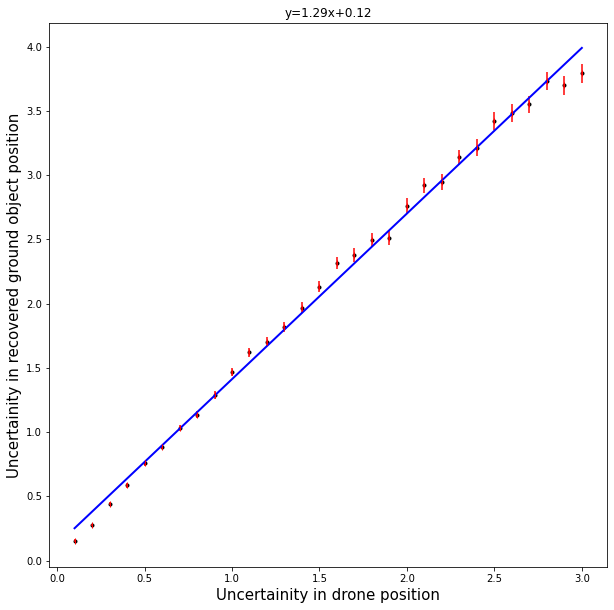

In [67]:
from sklearn import  linear_model
regr = linear_model.LinearRegression()     # Create linear regression object
regr.fit(df_g[['uncer_dp'] ],df_g[['uncer_rec_go']])     
plt.figure(figsize=(10,10))
plt.scatter(df_g[['uncer_dp'] ], df_g[['uncer_rec_go']], color='black', marker=".")
plt.title( 'y={:.2f}x+{:.2f}'.format( regr.coef_[0][0],regr.intercept_[0]))
plt.plot   (df_g[['uncer_dp'] ], regr.predict(df_g[['uncer_dp'] ]), color='blue', linewidth=2)
plt.errorbar(df_g['uncer_dp'] ,df_g['uncer_rec_go'], yerr=df_g['std_err_rec_go_pos'], fmt='|', color="red")
plt.xlabel("Uncertainity in drone position",fontdict={'fontsize':15})
plt.ylabel("Uncertainity in recovered ground object position",fontdict={'fontsize':15})
plt.rc('axes', labelsize=10) 
print('Coefficients: ', regr.coef_, 'Intercept: ', regr.intercept_)